# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra (eid: mm94424), Mihir Suvarna (eid: mms5776), Daniel Sialm (eid: dhs833)

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Letter recognition is a subtask of text recognition with wide applications as well - iPhones use letter recognition to convert handwritten characters to text. Due to the increasing importance of these tasks, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
from letter_recognition_functions import *
from ttf_to_png import *
from fontTools.ttLib import TTFont
%matplotlib inline

In [10]:
def convert_ttf(src_dir, dst_dir):
    DST_DIR = os.path.join(os.getcwd(), dst_dir)
    TEXTS_DIR = os.path.join(DST_DIR, "texts")
    IMAGES_DIR = os.path.join(DST_DIR, "images")
    # Get path using sys args, set up font loader
    SRC_DIR = os.path.join(os.getcwd(), src_dir)
    FONT_SIZE = "28"
    # Remove output directories if it exist
    if os.path.exists(DST_DIR):
        shutil.rmtree(DST_DIR)
    os.makedirs(DST_DIR)
    os.makedirs(TEXTS_DIR)
    os.makedirs(IMAGES_DIR)
    #TODO remove dir only if non-full
    # print("========= Starting TTF to PNG conversion =========")
    thumb_width = int(FONT_SIZE)
    # goes through each ttf file
    for file in os.listdir(SRC_DIR):
        if len(file) < 4 or file[-3:] != "ttf":
            print("ignored", file)
            continue
        TTF_PATH = os.path.join(SRC_DIR, file)
        TTF_NAME, TTF_EXT = os.path.splitext(os.path.basename(TTF_PATH))
        print(file)
        ttf = TTFont(TTF_PATH)
        # Make temporary directories
        # Writing each individual font character to file as texts
        x = ttf["cmap"].tables[0]
        # for x in ttf["cmap"].tables:
        for y in x.cmap.items():
            char_unicode = chr(y[0])
            char_utf8 = char_unicode.encode('utf_8')
            char_name = y[1]
            if len(char_name) == 1:
                # write each character to a new txt file
                if (char_name >= 'a' and char_name <= 'z') or (char_name >= 'A' and char_name <= 'Z'):
                    print(char_name, end = "")
                    upper = char_name.isupper()
                    case = '_upp' if upper else '_low'
                    f = open(os.path.join(TEXTS_DIR, char_name.lower() + case + '.txt'), 'wb')
                    f.write(char_utf8)
                    f.close()
        ttf.close()
        print()
        # Convert each txt file into a png
        files = os.listdir(TEXTS_DIR)
        for filename in files:
            name, ext = os.path.splitext(filename)
            input_txt = os.path.join(TEXTS_DIR, filename)
            output_png = os.path.join(IMAGES_DIR, TTF_NAME + "_" + name + ".png")
            subprocess.call(["convert", "-font", TTF_PATH, "-pointsize", FONT_SIZE, "label:@" + input_txt, output_png])
        
        # clear out the text directory since we are done with it
        shutil.rmtree(TEXTS_DIR)
        os.makedirs(TEXTS_DIR)

        # print("TTF -> Image Conversion finished for", str(file))

        # Normalizing the images to all be of the correct size
        files = glob.glob(os.path.join(IMAGES_DIR, '*.png'))
        for f in files:
            im = Image.open(f).convert('RGB')
            im = ImageOps.invert(im)
            im_thumb = im.resize((thumb_width, thumb_width), Image.LANCZOS)
            ftitle, fext = os.path.splitext(os.path.basename(f))
            im_thumb.save(os.path.join(DST_DIR, ftitle + fext))

        # done with the image directory
        shutil.rmtree(IMAGES_DIR)
        os.makedirs(IMAGES_DIR)
    #     print("Images -> Cropped Images for", str(file))
    # # print("========= Full TTF to PNG conversion done =========")
    shutil.rmtree(TEXTS_DIR)
    shutil.rmtree(IMAGES_DIR)

In [11]:
src_dir = 'data/collected_ttfs'
dst_dir = 'data/collected_letters_pngs'

convert_ttf(src_dir, dst_dir)


P0-Regular.ttf
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
ignored .DS_Store
P1-Regular.ttf
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


## Dataset

We collected handwritten letters from 23 students, each of whom wrote the alphabet 10 times. This gave us about 6K data points to train and test our model.

In [12]:
letter_to_label = dict()
classes = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes)):
    letter_to_label[classes[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [3]:
src_dir = 'data/collected_ttfs'
dst_dir = 'data/collected_letters_pngs'
# convert ttf into pngs (may have to remove local dst_dir if images are not loaded in)
# - we can check this by seeing if there are the correct number of images

In [13]:
import torchvision.transforms as transforms

src_dir = 'data/collected_letters_pngs'
transform = transforms.ToTensor()

files_train = []
files_val = []
files_test = []
for i in range(0,16): files_train.append('P' + str(i))
for i in range(16,21): files_val.append('P' + str(i))
for i in range(21,24): files_test.append('P' + str(i))

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    file = ftitle.split("_")[0].split("-")[0]
    im = Image.open(f).convert('L')

    if file in files_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif file in files_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    elif file in files_test:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])

In [14]:
train_loader_collected = create_loader(imgs_train, labels_train)
val_loader_collected = create_loader(imgs_val, labels_val)
test_loader_collected = create_loader(imgs_test, labels_test)

ValueError: num_samples should be a positive integer value, but got num_samples=0

Label: s


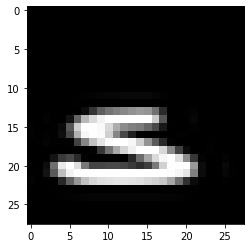

In [6]:
# Visualization for our collected dataset
img, label = get_input(train_loader_collected)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Defining a basic LetterCNN

We define a basic CNN with 1 convolutional layer, 1 MaxPool layer, a ReLU activation and finally a fully connected layer for our model. This model will be used throughout our prelimenary expriments (i.e. before our computational experiments).

In [7]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

## Testing the basic LetterCNN

In [8]:
basic_model_collected = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model_collected.parameters(), lr=1e-3)
train_network(basic_model_collected, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.36536
   Val loss: 2.24164

EPOCH 1
 Train loss: 1.00289
   Val loss: 2.13276

EPOCH 2
 Train loss: 0.57645
   Val loss: 2.20952

EPOCH 3
 Train loss: 0.36731
   Val loss: 2.50624

EPOCH 4
 Train loss: 0.23313
   Val loss: 2.61337

EPOCH 5
 Train loss: 0.15150
   Val loss: 2.82234

EPOCH 6
 Train loss: 0.10533
   Val loss: 2.94545

EPOCH 7
 Train loss: 0.07439
   Val loss: 3.15267

EPOCH 8
 Train loss: 0.05384
   Val loss: 3.19686

EPOCH 9
 Train loss: 0.04007
   Val loss: 3.47029



Test accuracy: 48.718


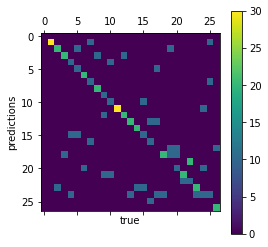

In [9]:
acc, true, pred = test_network(basic_model_collected, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model_collected.classes), pred, true)

We see quite a bit of overfitting (since the validation loss is not converging and, in fact, even increasing). This naturally causes our accuracy to be quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained. This causes our model to be biased towards the the handwriting of a few people and prevents it from generalizing well. Thus, we will combine our dataset with the EMNIST dataset to create a better model.

## EMNIST Dataset

In [10]:
# Download the EMNIST dataset and load it as tensors
from torchvision import datasets, transforms

save_dir = 'EMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: EMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
# Create samplers for the training and validation sets
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.78*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [12]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Label: z


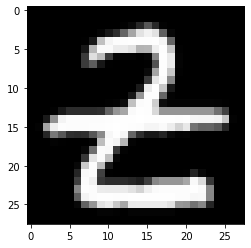

In [13]:
# Visualization EMNIST
img, label = get_input(train_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)).T, cmap='Greys_r')
print("Label: %s" % classes[label])

## Combining EMNIST with our Data

In [14]:
combined_train_loader = combine_loaders(train_loader, train_loader_collected, fromEMNIST=True)
combined_val_loader = combine_loaders(val_loader, val_loader_collected, fromEMNIST=True)
combined_test_loader = combine_loaders(test_loader, test_loader_collected, fromEMNIST=True)

Label: r


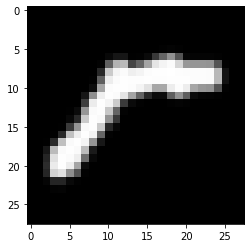

In [15]:
# Verifying combined
img, label = get_input(combined_test_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Making a new LetterCNN on the Combined Dataset

In [16]:
basic_model = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=1e-3)
train_network(basic_model, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.26092
   Val loss: 0.96917

EPOCH 1
 Train loss: 0.71596
   Val loss: 0.73607

EPOCH 2
 Train loss: 0.55114
   Val loss: 0.65744

EPOCH 3
 Train loss: 0.47381
   Val loss: 0.61841

EPOCH 4
 Train loss: 0.42534
   Val loss: 0.60125

EPOCH 5
 Train loss: 0.38818
   Val loss: 0.60538

EPOCH 6
 Train loss: 0.36274
   Val loss: 0.59775

EPOCH 7
 Train loss: 0.33941
   Val loss: 0.58978

EPOCH 8
 Train loss: 0.32381
   Val loss: 0.59429

EPOCH 9
 Train loss: 0.30731
   Val loss: 0.58883



Test accuracy: 86.687


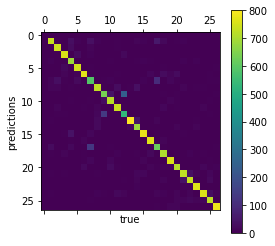

In [17]:
acc, true, pred = test_network(basic_model, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model.classes), pred, true)

We see immediate improvement in our results. The new model does not overfit (since the validation loss decreases) and generalizes quite well, giving us an accuracy of about 86%, an increase of about 79% in accuracy compared to our older model. This shows that our model works well if a good dataset is provided. 

## Computational Experiment 1 - Regularization

Our first set of computational experiments will deal with better regularization of our model in hopes of creating a more generalized model. 

### 1a) Regularization through data augmentation - add digital fonts

For this experiment, we add digital fonts to our dataset. Specifically, we take about 100 different fonts and add their characters to our dataset. We hypothesize that this will increase the accuracy of our model.

In [ ]:
src_dir = 'data/digital_ttfs'
dst_dir = 'data/digital_letters_pngs'
# convert ttf into pngs (may have to remove local dst_dir if images are not loaded in)
# - we can check this by seeing if there are the correct number of images

In [17]:
src_dir = "data/digital_letters_pngs"
idx = 0

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < 1820:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif idx < 2210:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])
    
    idx += 1

In [18]:
train_loader_digital = create_loader(imgs_train, labels_train)
val_loader_digital = create_loader(imgs_val, labels_val)
test_loader_digital = create_loader(imgs_test, labels_test)

Label: a


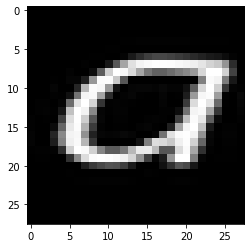

In [19]:
# Visualization of a digital font
img, label = get_input(train_loader_digital)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [20]:
# Combine digital with other data
combined_train_digital_loader = combine_loaders(combined_train_loader, train_loader_digital)
combined_val_digital_loader = combine_loaders(combined_val_loader, val_loader_digital)
combined_test_digital_loader = combine_loaders(combined_test_loader, test_loader_digital)

Label: h


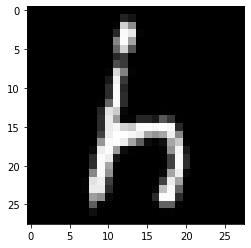

In [21]:
# Verifiying combined
img, label = get_input(combined_test_digital_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [22]:
# Train model with augmented data
model_digital = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.19698
   Val loss: 0.83283

EPOCH 1
 Train loss: 0.61499
   Val loss: 0.64866

EPOCH 2
 Train loss: 0.48866
   Val loss: 0.60812

EPOCH 3
 Train loss: 0.43252
   Val loss: 0.58670

EPOCH 4
 Train loss: 0.39702
   Val loss: 0.58440

EPOCH 5
 Train loss: 0.37035
   Val loss: 0.59076

EPOCH 6
 Train loss: 0.35144
   Val loss: 0.56263

EPOCH 7
 Train loss: 0.33323
   Val loss: 0.56322

EPOCH 8
 Train loss: 0.32022
   Val loss: 0.56664

EPOCH 9
 Train loss: 0.30677
   Val loss: 0.56248



Test accuracy: 86.294


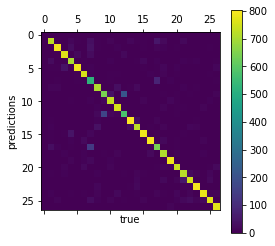

In [23]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

The accuracy of the model with the augmented data did not improve (in fact, it decreased by about 0.4%). It is possible that this happened because we only included 100 fonts - we believe that including more fonts in our dataset should improve the accuracy of our model. However, given current results, it is reasonable to say that the improvement in accuracy will not be very significant even if more fonts are added. 

### 1b) Regularization through dropout

We hypothesize that adding dropout will decrease the accuracy of our model because each image is simply a 28 x 28 image of a letter, and dropping out even the smallest learned feature for a small image should impact the accuracy negatively.

In [24]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [25]:
model_dropout = letterCNNDropout(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.21749
   Val loss: 0.89990

EPOCH 1
 Train loss: 0.70964
   Val loss: 0.74894

EPOCH 2
 Train loss: 0.59830
   Val loss: 0.69497

EPOCH 3
 Train loss: 0.53525
   Val loss: 0.67247

EPOCH 4
 Train loss: 0.49095
   Val loss: 0.64186

EPOCH 5
 Train loss: 0.46145
   Val loss: 0.63745

EPOCH 6
 Train loss: 0.43752
   Val loss: 0.62883

EPOCH 7
 Train loss: 0.42047
   Val loss: 0.62788

EPOCH 8
 Train loss: 0.40495
   Val loss: 0.62291

EPOCH 9
 Train loss: 0.39452
   Val loss: 0.63649



Test accuracy: 84.773


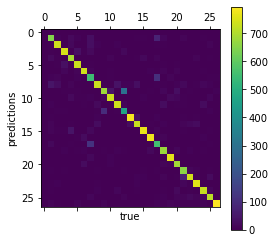

In [26]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

As hypothesized, the accuracy of our model did drop using dropout.

### 1c) Regularization through Average Pooling

We hypothesize that the accuracy of our model will stay about the same with average pooling. We believe this to be the case because we have a network with just one convolutional layer which learns on fairly small images. 

Label: x


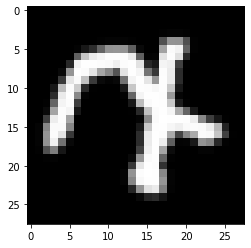

In [31]:
# Visualizing the combined dataset 
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

torch.Size([1, 8, 24, 24])


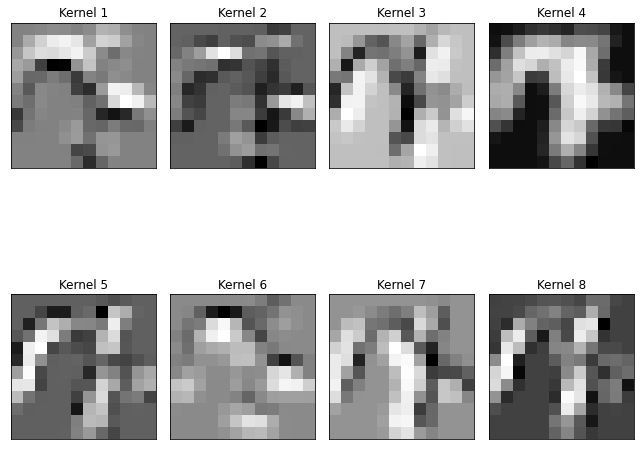

In [42]:
# visualize kernels with max pooling
conv_out = basic_model.layers[0](img)
_ = display_pool_outputs(basic_model.layers[1], conv_out)

We see that the kernels are a little blotchy. This is to be expected as a result of max pooling. The learned kernels with average pooling should be a little smoother. 

In [34]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [19]:
model_avgpool = letterCNNAvgPool(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.28857
   Val loss: 1.01285

EPOCH 1
 Train loss: 0.77621
   Val loss: 0.80283

EPOCH 2
 Train loss: 0.62306
   Val loss: 0.72589

EPOCH 3
 Train loss: 0.55288
   Val loss: 0.68451

EPOCH 4
 Train loss: 0.50584
   Val loss: 0.67005

EPOCH 5
 Train loss: 0.47186
   Val loss: 0.65374

EPOCH 6
 Train loss: 0.44094
   Val loss: 0.63591

EPOCH 7
 Train loss: 0.41464
   Val loss: 0.62712

EPOCH 8
 Train loss: 0.39286
   Val loss: 0.63792

EPOCH 9
 Train loss: 0.37321
   Val loss: 0.62255



Test accuracy: 84.968


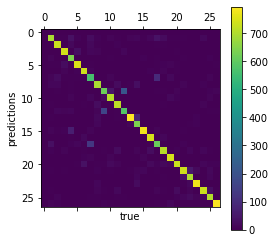

In [20]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

torch.Size([1, 8, 24, 24])


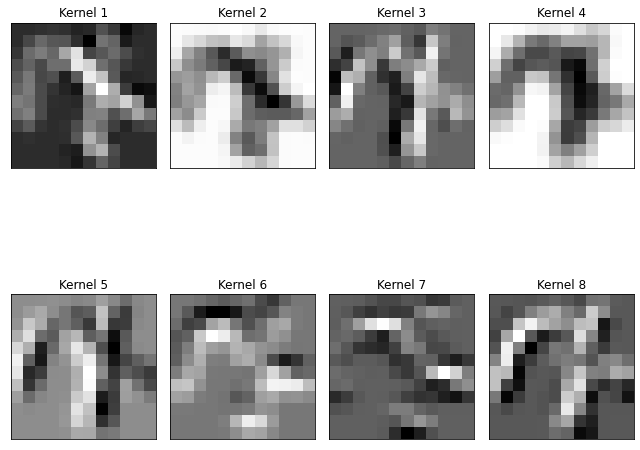

In [43]:
# visualize average pooling
conv_out = model_avgpool.layers[0](img)
_ = display_pool_outputs(model_avgpool.layers[1], conv_out)

The learned kernels for average pooling are smoother than the learned kernels for max pooling, as expected. As hypothesized, the accuracy of our model did not improve with average pooling. However, it is interesting that the accuracy decreased a bit with average pooling. This suggests that, for the task of letter recognition, max pooling is a better strategy than average pooling. 

### 1d) Regularization through Early Stopping

As our final experiment for the first computational experiment, we implement early stopping. We hypothesize that early stopping should improve the accuracy marginally. 

In [30]:
model_early_stopping = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, early_stopping=True)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.16267
   Val loss: 0.86680

EPOCH 1
 Train loss: 0.64341
   Val loss: 0.69299

EPOCH 2
 Train loss: 0.52429
   Val loss: 0.67110

EPOCH 3
 Train loss: 0.46574
   Val loss: 0.62997

EPOCH 4
 Train loss: 0.42519
   Val loss: 0.62439

EPOCH 5
 Train loss: 0.39421
   Val loss: 0.60525

EPOCH 6
 Train loss: 0.36869
   Val loss: 0.60419

EPOCH 7
 Train loss: 0.34533
   Val loss: 0.60374

EPOCH 8
 Train loss: 0.32654
   Val loss: 0.59719

EPOCH 9
 Train loss: 0.30961
   Val loss: 0.60095

EPOCH 10
 Train loss: 0.29568
   Val loss: 0.60462

EPOCH 11
 Train loss: 0.28227
   Val loss: 0.60241

EPOCH 12
 Train loss: 0.26999
   Val loss: 0.60328

EPOCH 13
 Train loss: 0.26197
   Val loss: 0.60111

EPOCH 14
 Train loss: 0.25354
   Val loss: 0.61228

EPOCH 15
 Train loss: 0.24543
   Val loss: 0.61002

EPOCH 16
 Train loss: 0.23798
   Val loss: 0.61936

EPOCH 17
 Train loss: 0.23027
   Val loss: 0.62318

EPOCH 18
 Train loss: 0.22342
   Val loss: 0.64030

Early stopping in epoc

Test accuracy: 86.501


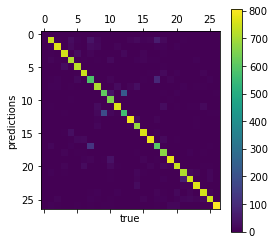

In [31]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

The accuracy of our model with early stopping did not improve and stayed about the same. 

All these computational experiments show that, as defined, our `letterCNN` is actually well defined and supports a good amount of generalization. To get good results, then, we must pick the dataset carefully so that our model generalizes to a variety of handwriting and font styles. 

## Computational Experiment 2 - Architecture

As our second computational experiment, we will visualize the learned kernels of our basic model and then change the architecture to create a new model in hopes of creating a more accurate network. 

### Visualizing previous kernels

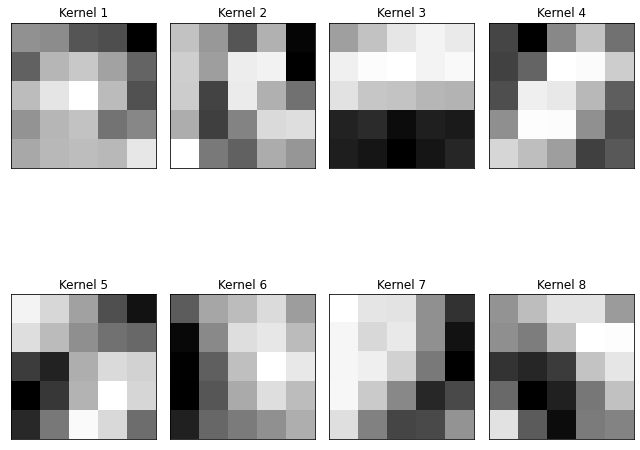

In [32]:
# extract the weights from the learned model
conv1wt = basic_model.layers[0].weight.data.numpy()
display_kernels(conv1wt)

It seems that in our basic model, the kernels are learning to identify specific edge types within letters. For example, in Kernel 3, it seems that the model is learning to identify horizontal edges while in Kernel 6 the model is learning to identify vertical edges. Based upon this, we hypothesize that adding a second convolutional layer to our current model will help it learn the features/characterisitics of each letter better.

### 2a) Double Convolutional Layer

In [51]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [52]:
model_double_layer = letterCNNDouble(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.87897
   Val loss: 0.58262

EPOCH 1
 Train loss: 0.39369
   Val loss: 0.47120

EPOCH 2
 Train loss: 0.29961
   Val loss: 0.40672

EPOCH 3
 Train loss: 0.25030
   Val loss: 0.40483

EPOCH 4
 Train loss: 0.21935
   Val loss: 0.38776

EPOCH 5
 Train loss: 0.19568
   Val loss: 0.38271

EPOCH 6
 Train loss: 0.17522
   Val loss: 0.39793

EPOCH 7
 Train loss: 0.16064
   Val loss: 0.40440

EPOCH 8
 Train loss: 0.14737
   Val loss: 0.40021

EPOCH 9
 Train loss: 0.13513
   Val loss: 0.42680



Test accuracy: 90.491


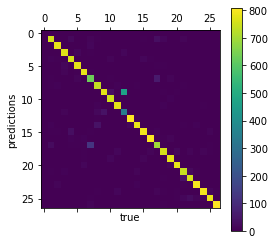

In [53]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

As we can see, adding a seecond layer did indeed increase the accuracy by about 4% as per our hypothesis.

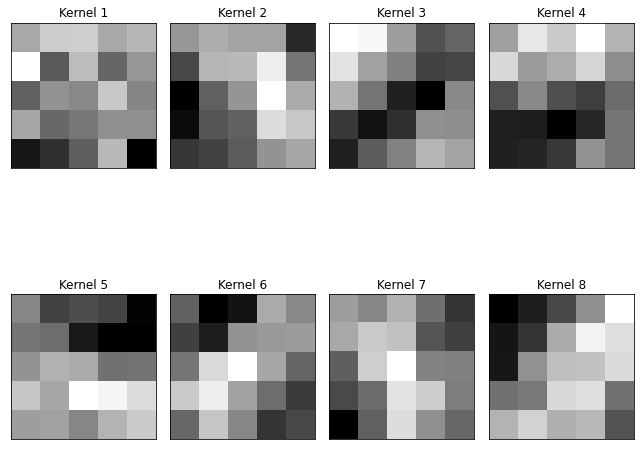

In [54]:
# extract the weights from the learned model
conv2wtsfirst = model_double_layer.layers[0].weight.data.numpy()
display_kernels(conv2wtsfirst)

The first layer is still learning the hard edges of each letter as the single convolutional layer network (i.e. our basic model).

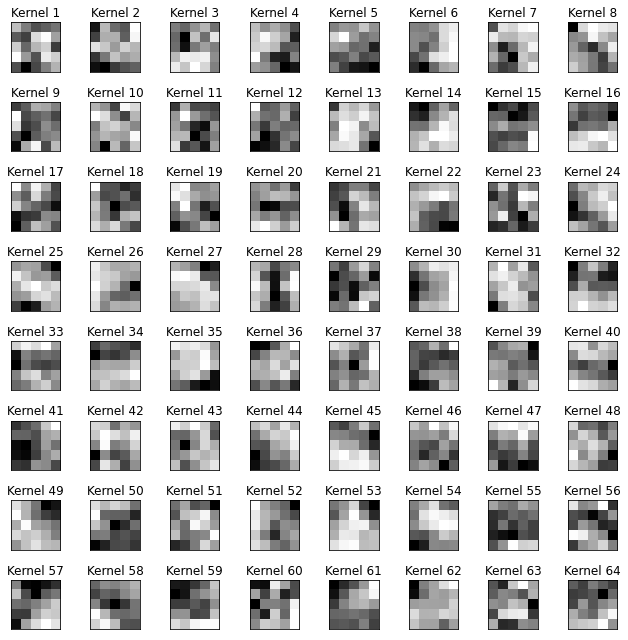

In [55]:
# extract the weights from the learned model
conv2wtssecond = model_double_layer.layers[3].weight.data.numpy()
display_kernels(conv2wtssecond)

The second layer seems to be learning more precise/specific features. Note that we only display the first channel of each of the 64 channels in the second convolution layer in `letterCNNDouble`. Still, it is quite obvious that the second layer's kernels are learning more precise features. It seems that the second layer is starting to learn more nuances between the edges of each letter - however, that is much harder to confirm. Still, as hypothesized, adding a second convolution layer to our basic CNN helped the new model learn more precise features about each letter and this in turn increased the accuracy of our new model. 

### 2b) Changing the Kernel Size

In [38]:
class letterCNNKernel(nn.Module):
    def __init__(self, classes, size):
        super().__init__()
        self.classes = classes
        output_size = (((28 - size) + 1) // 2) ** 2 * 8 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(size,size), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(output_size, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

#### Size 3 kernel

In [39]:
model_kernel_3 = letterCNNKernel(classes, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_3.parameters(), lr=1e-3)
train_network(model_kernel_3, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.35787
   Val loss: 1.08603

EPOCH 1
 Train loss: 0.84588
   Val loss: 0.85211

EPOCH 2
 Train loss: 0.66974
   Val loss: 0.77046

EPOCH 3
 Train loss: 0.58562
   Val loss: 0.72727

EPOCH 4
 Train loss: 0.53612
   Val loss: 0.72036

EPOCH 5
 Train loss: 0.49884
   Val loss: 0.69246

EPOCH 6
 Train loss: 0.46967
   Val loss: 0.67759

EPOCH 7
 Train loss: 0.44942
   Val loss: 0.67346

EPOCH 8
 Train loss: 0.43004
   Val loss: 0.66066

EPOCH 9
 Train loss: 0.41421
   Val loss: 0.66084



Test accuracy: 83.897


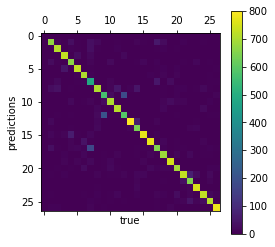

In [40]:
acc, true, pred = test_network(model_kernel_3, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_3.classes), pred, true)

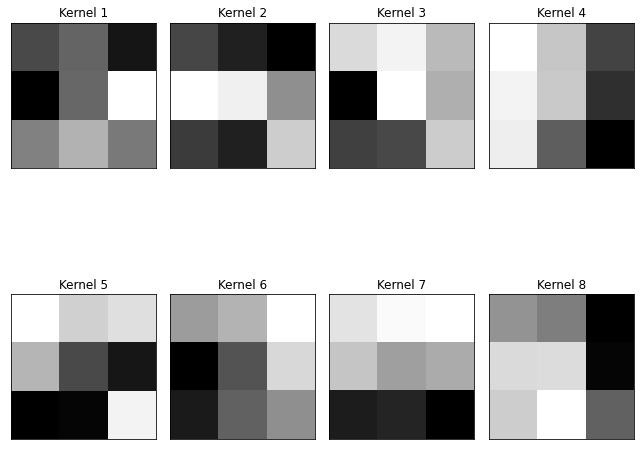

In [41]:
# extract the weights from the learned model
convk3wts = model_kernel_3.layers[0].weight.data.numpy()
display_kernels(convk3wts)

#### Size 8 kernel

In [42]:
model_kernel_8 = letterCNNKernel(classes, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_8.parameters(), lr=1e-3)
train_network(model_kernel_8, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.17771
   Val loss: 0.84387

EPOCH 1
 Train loss: 0.63968
   Val loss: 0.65673

EPOCH 2
 Train loss: 0.51286
   Val loss: 0.60829

EPOCH 3
 Train loss: 0.44722
   Val loss: 0.58617

EPOCH 4
 Train loss: 0.40550
   Val loss: 0.57547

EPOCH 5
 Train loss: 0.37588
   Val loss: 0.55991

EPOCH 6
 Train loss: 0.34994
   Val loss: 0.57010

EPOCH 7
 Train loss: 0.33404
   Val loss: 0.56971

EPOCH 8
 Train loss: 0.31950
   Val loss: 0.56214

EPOCH 9
 Train loss: 0.30454
   Val loss: 0.56568



Test accuracy: 86.775


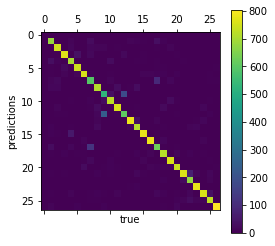

In [43]:
acc, true, pred = test_network(model_kernel_8, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_8.classes), pred, true)

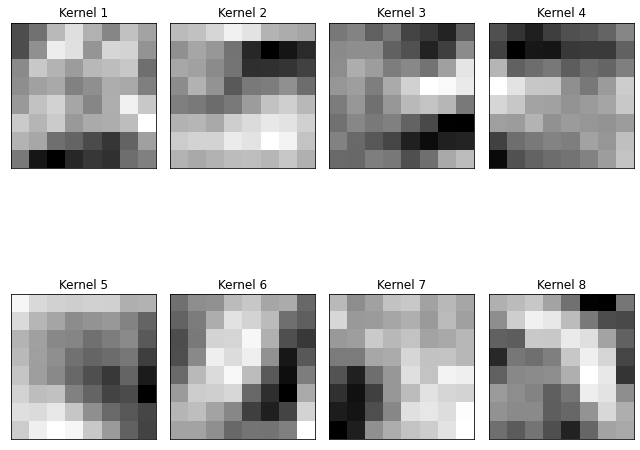

In [44]:
# extract the weights from the learned model
convk8wts = model_kernel_8.layers[0].weight.data.numpy()
display_kernels(convk8wts)

#### Size 11 kernel

In [45]:
model_kernel_11 = letterCNNKernel(classes, 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_11.parameters(), lr=1e-3)
train_network(model_kernel_11, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.10215
   Val loss: 0.76172

EPOCH 1
 Train loss: 0.58019
   Val loss: 0.62596

EPOCH 2
 Train loss: 0.47709
   Val loss: 0.59737

EPOCH 3
 Train loss: 0.42738
   Val loss: 0.56521

EPOCH 4
 Train loss: 0.39430
   Val loss: 0.54805

EPOCH 5
 Train loss: 0.37169
   Val loss: 0.55698

EPOCH 6
 Train loss: 0.35286
   Val loss: 0.53725

EPOCH 7
 Train loss: 0.33749
   Val loss: 0.54670

EPOCH 8
 Train loss: 0.32512
   Val loss: 0.55393

EPOCH 9
 Train loss: 0.31350
   Val loss: 0.55885



Test accuracy: 86.747


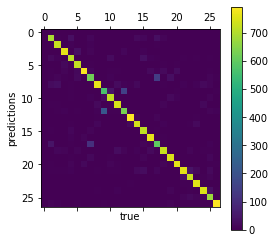

In [46]:
acc, true, pred = test_network(model_kernel_11, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_11.classes), pred, true)

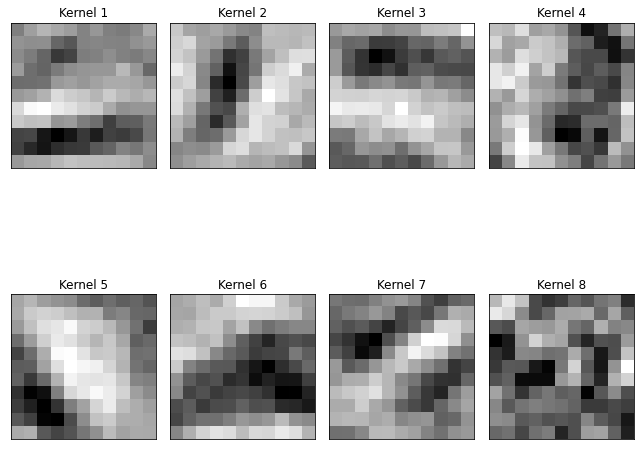

In [47]:
# extract the weights from the learned model
convk11wts = model_kernel_11.layers[0].weight.data.numpy()
display_kernels(convk11wts)

## Optimized Inputs

In [48]:
optimized_inputs_kernel_3 = get_optimized_inputs(model_kernel_3, nepochs=1000)
optimized_inputs_kernel_5 = get_optimized_inputs(basic_model, nepochs=1000)
optimized_inputs_kernel_8 = get_optimized_inputs(model_kernel_8, nepochs=1000)
optimized_inputs_kernel_11 = get_optimized_inputs(model_kernel_11, nepochs=1000)
optimized_inputs_double_conv = get_optimized_inputs(model_double_layer, nepochs=1000, validate_loss=True)

finished N/A with 0.04458 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00018 loss	Expected: a. Predicted: a.
finished b with 0.00020 loss	Expected: b. Predicted: b.
finished c with 0.00012 loss	Expected: c. Predicted: c.
finished d with 0.00034 loss	Expected: d. Predicted: d.
finished e with 0.00011 loss	Expected: e. Predicted: e.
finished f with 0.00016 loss	Expected: f. Predicted: f.
finished g with 0.00014 loss	Expected: g. Predicted: g.
finished h with 0.00008 loss	Expected: h. Predicted: h.
finished i with 0.00004 loss	Expected: i. Predicted: i.
finished j with 0.00006 loss	Expected: j. Predicted: j.
finished k with 0.00008 loss	Expected: k. Predicted: k.
finished l with 0.00006 loss	Expected: l. Predicted: l.
finished m with 0.00013 loss	Expected: m. Predicted: m.
finished n with 0.00012 loss	Expected: n. Predicted: n.
finished o with 0.00034 loss	Expected: o. Predicted: o.
finished p with 0.00017 loss	Expected: p. Predicted: p.
finished q with 0.00020 loss	Expected: q. 

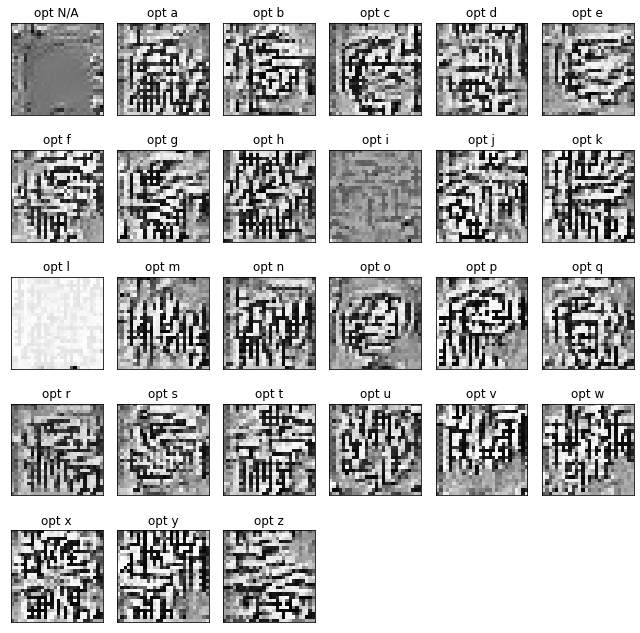

In [49]:
display_optimized_inputs(optimized_inputs_kernel_3)

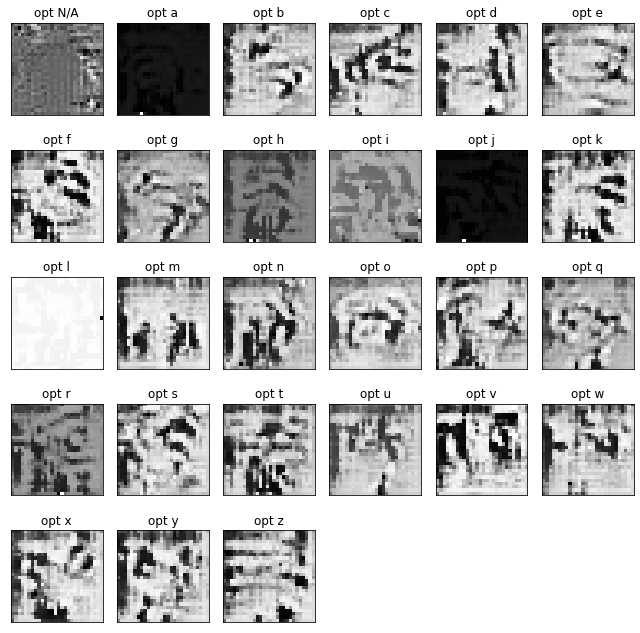

In [50]:
display_optimized_inputs(optimized_inputs_kernel_5)

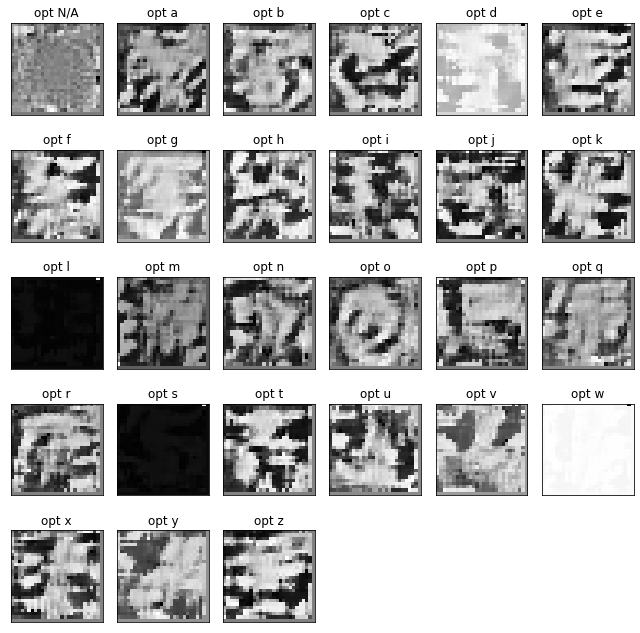

In [51]:
display_optimized_inputs(optimized_inputs_kernel_8)

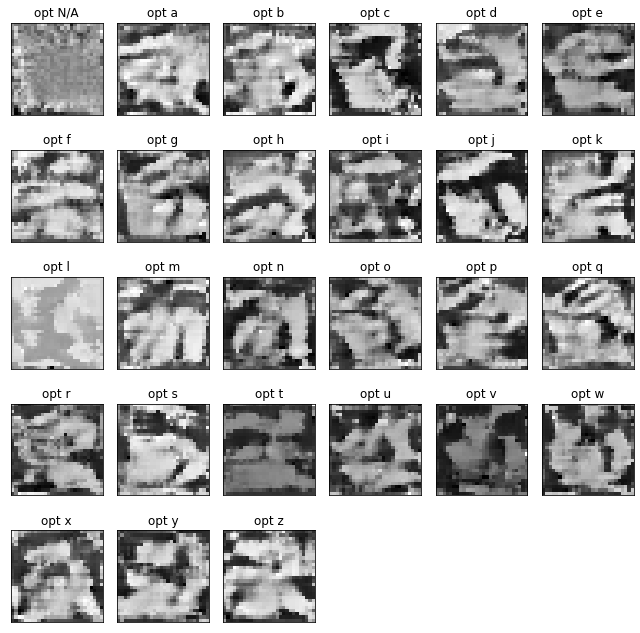

In [52]:
display_optimized_inputs(optimized_inputs_kernel_11)

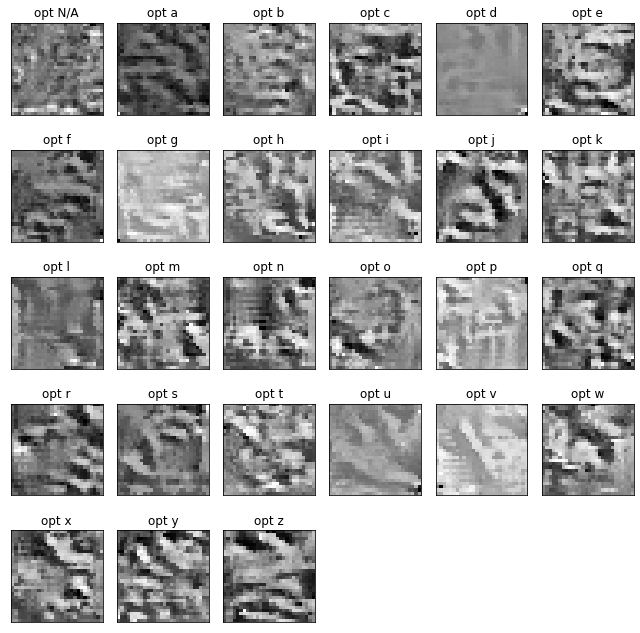

In [53]:
display_optimized_inputs(optimized_inputs_double_conv)

## Additional Visualizations

We provide some additional visualizations here for reference. 

Label: p


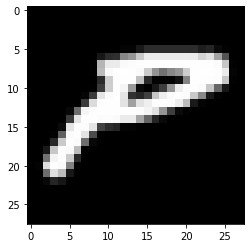

In [46]:
# Visualizing a different letter from the combined dataset
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

#### Single Convolution Layer

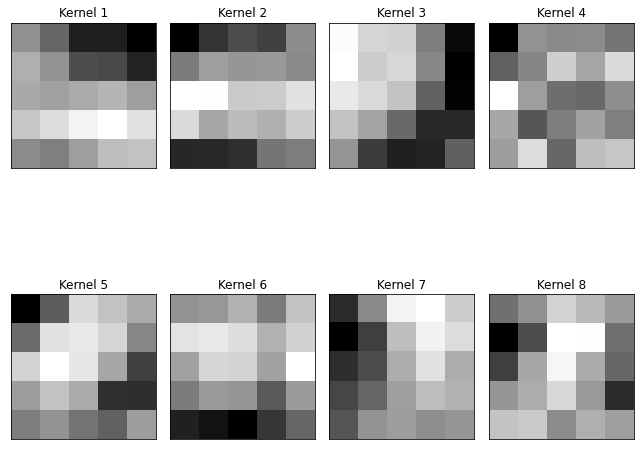

In [47]:
# Visualizing the learned kernels for the sinlge convolutional layer network
conv1_layer = basic_model.layers[0]
display_kernels(conv1_layer.weight.data.numpy())

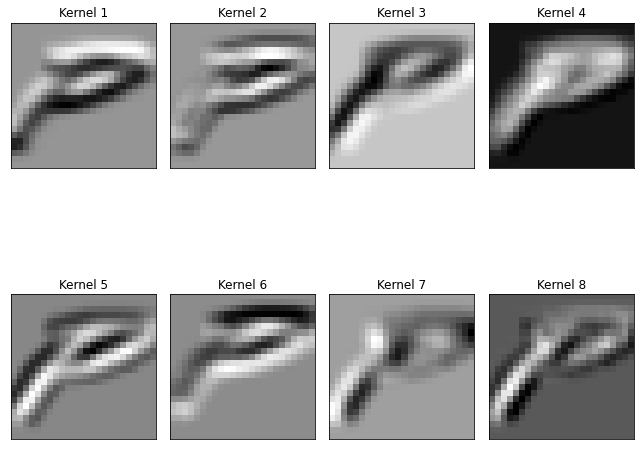

In [48]:
# Visualizing convolved outputs for the sinlge convolutional layer network
conv_outs = display_conv_outputs(conv1_layer, img)

torch.Size([1, 8, 24, 24])


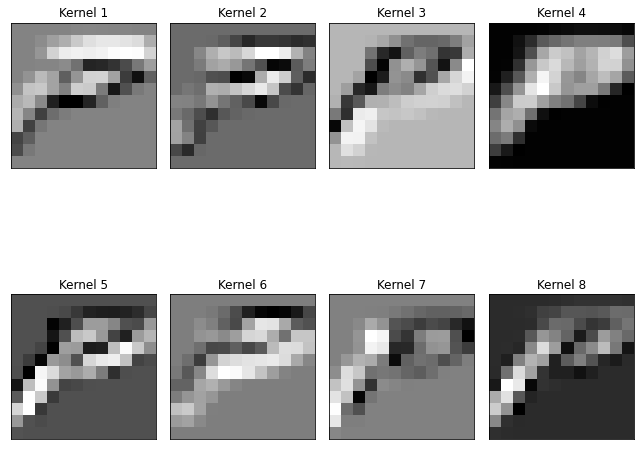

In [49]:
# Visualizing the max pooling layer outputs for the sinlge convolutional layer network
_ = display_pool_outputs(basic_model.layers[1], conv_outs)

#### Double Convolutional Layer

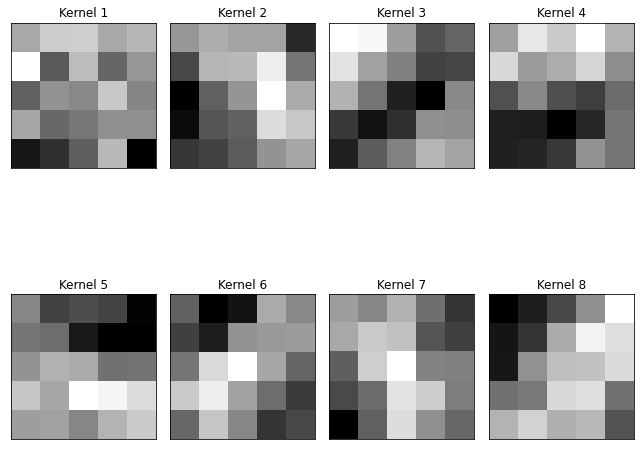

In [56]:
# Visualizing the learned kernels of the first convolution layer of the double covolutional network
conv2_layer1 = model_double_layer.layers[0]
display_kernels(conv2_layer1.weight.data.numpy())

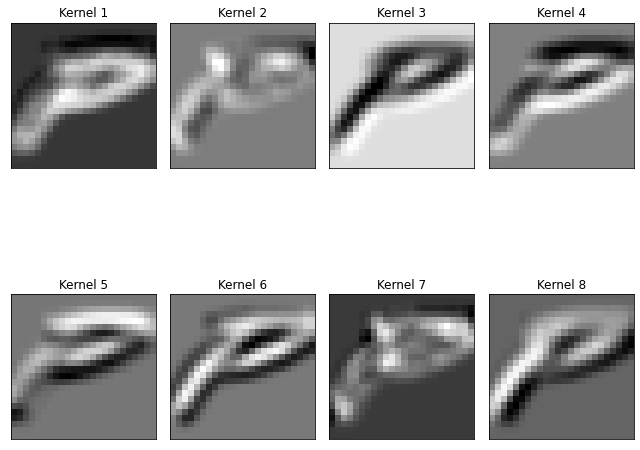

In [57]:
# Visualizing the convolved outputs of first convolution layer of the double covolutional network
outs_layer1 = display_conv_outputs(model_double_layer.layers[0], img)

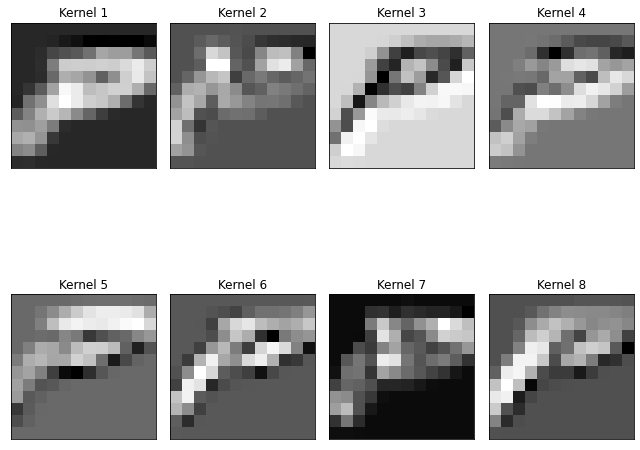

In [61]:
# Visualizing the max pool outputs of the first max pool layer of the double covolutional network
pooled_layer1 = display_pool_outputs(model_double_layer.layers[1], outs_layer1)

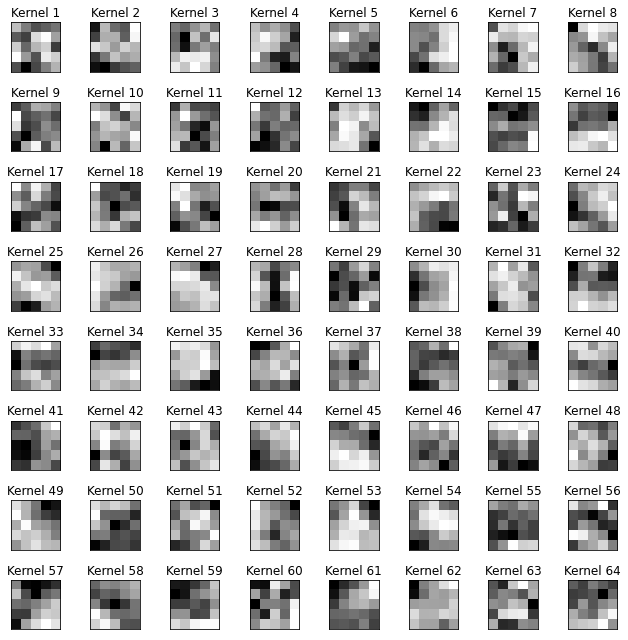

In [62]:
# Visualizing the learned kernels of the second convolution layer of the double covolutional network
conv2_layer2 = model_double_layer.layers[3]
display_kernels(conv2_layer2.weight.data.numpy())

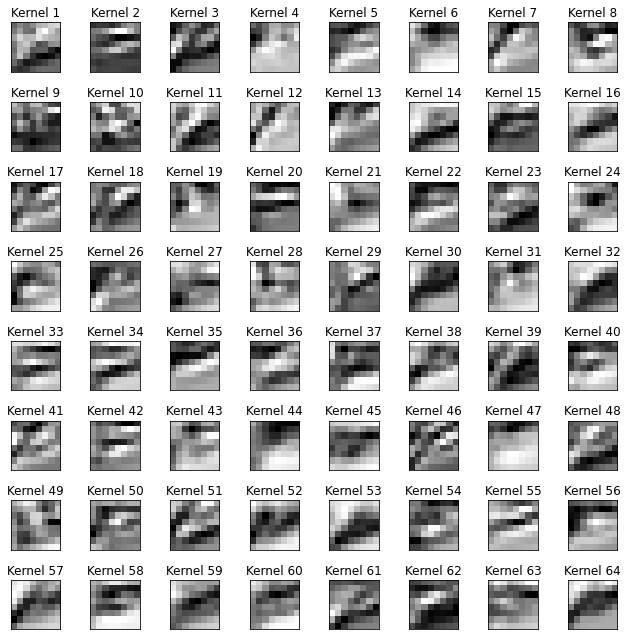

In [65]:
# Visualizing the convolved outputs of the second convolution layer of the double covolutional network
inputs_layer2 = model_double_layer.layers[2](pooled_layer1)
outs_layer2 = display_conv_outputs(model_double_layer.layers[3], inputs_layer2)

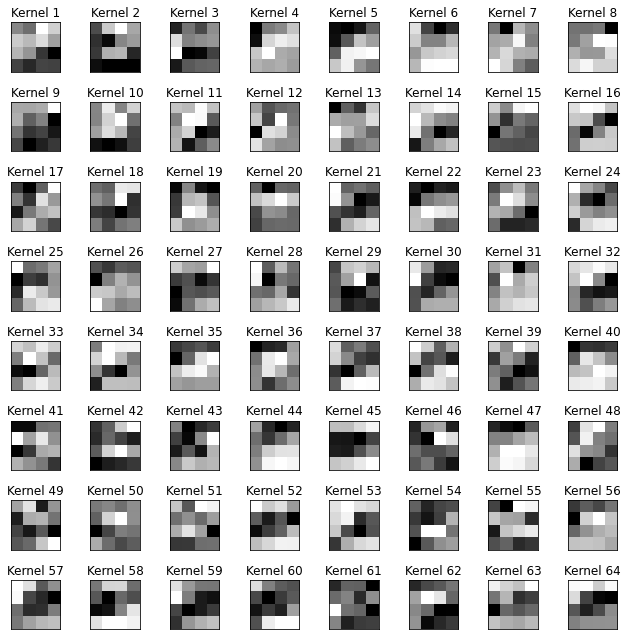

In [66]:
# Visualizing the max pool outputs of second max pool layer of the double covolutional network
_ = display_pool_outputs(model_double_layer.layers[4], outs_layer2)